In [1]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from kornia.enhance import normalize
from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm.auto import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform
from model import ConvNN, display_model

# os
import os
import path

import random
import numpy as np 

# transformations
# import transform as T
# from randaugment import RandomAugment

# typing
from typing import Callable, List, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%load_ext autoreload
%autoreload 2

In [2]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [3]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [4]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95 #! 0.95 in the paper
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.001

In [5]:
class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)
        # x = self.softmax(x)

        return x

In [6]:
def compute_mean_std(trainLoader) -> Tuple[List[float], List[float]]:
    # initialize the list of means and stds
    mean, std = torch.zeros(3), torch.zeros(3)

    # iterate over the dataset and compute the sum of each channel
    for images, _ in trainLoader:
        mean+= torch.mean(images, dim=[0,2,3])
        std+= torch.std(images, dim=[0,2,3])
    
    # compute the mean and std
    mean = mean/len(trainLoader)
    std = std/len(trainLoader)

    return mean, std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

if not os.path.exists('./data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')
else:
    mean, std = torch.load('./data/mean.pt'), torch.load('./data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
mean: [0.4913966  0.48215377 0.44651437], std: [0.246344   0.24280126 0.26067406]
Files already downloaded and verified


In [7]:
torch_models = 'torch_models' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## III. Semi-Supervised Learning: Fixmatch

### III.1 Fixmatch on 10% train data

In [8]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.10

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [9]:
# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

In [10]:
def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

In [11]:
model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [12]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, max_qb.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)


Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 23.31%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 35.43%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 41.18%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.08%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 46.51%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 45.9%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.63%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.85%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 52.36%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 55.09%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.25%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.42%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.68%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.11%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.58%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.03%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.96%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.66%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.03%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.77%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.59%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.61%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.4%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 61.64%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.47%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.91%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.59%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.89%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.4%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.88%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.8%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.93%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.61%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.41%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.66%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.3%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.83%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.51%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.88%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.83%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.16%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.84%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.33%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.23%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.48%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.17%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.81%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.72%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.98%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.11%


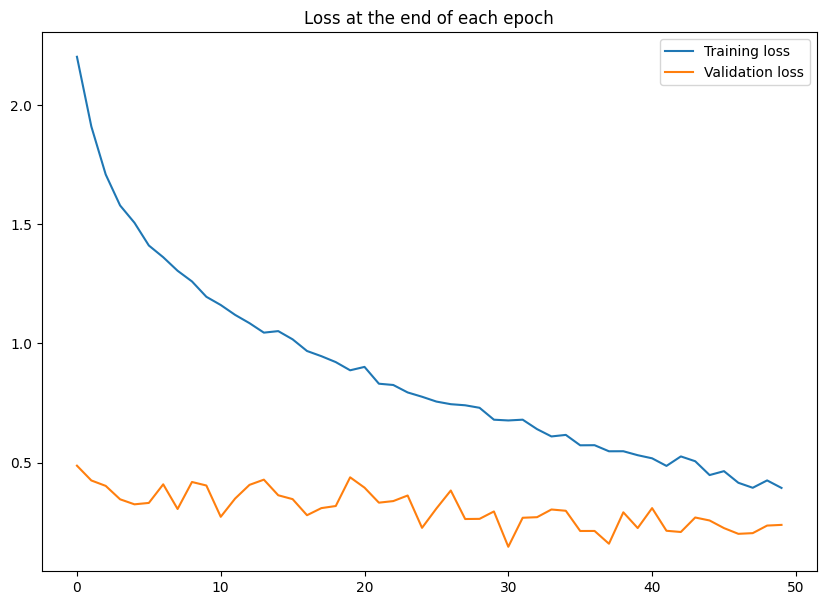

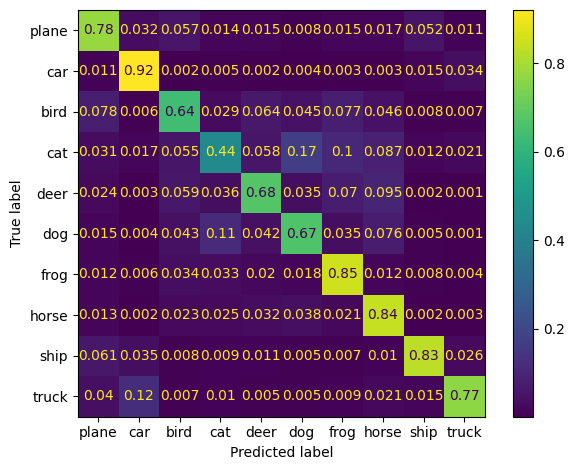

In [13]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


Test Accuracy: 74.11%


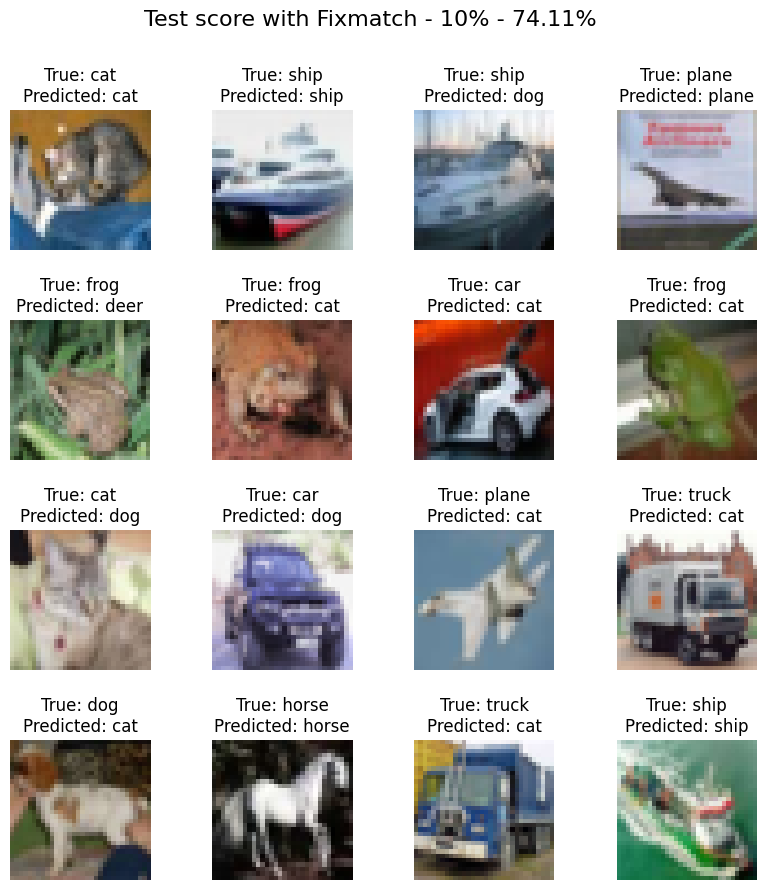

In [14]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")

### III.2 Fixmatch on 5% train data

In [15]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.05

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [16]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, max_qb.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)


Start training


Epoch     0:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 20.96%


Epoch     1:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 21.95%


Epoch     2:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 31.26%


Epoch     3:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 33.5%


Epoch     4:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 37.06%


Epoch     5:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 39.55%


Epoch     6:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 39.48%


Epoch     7:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.22%


Epoch     8:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 44.86%


Epoch     9:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 47.45%


Epoch    10:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 41.03%


Epoch    11:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.69%


Epoch    12:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.25%


Epoch    13:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 52.38%


Epoch    14:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 53.46%


Epoch    15:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.39%


Epoch    16:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 54.75%


Epoch    17:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.7%


Epoch    18:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.4%


Epoch    19:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.04%


Epoch    20:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 53.41%


Epoch    21:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.43%


Epoch    22:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.58%


Epoch    23:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.72%


Epoch    24:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.28%


Epoch    25:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.91%


Epoch    26:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.89%


Epoch    27:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.2%


Epoch    28:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.98%


Epoch    29:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.61%


Epoch    30:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.32%


Epoch    31:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.05%


Epoch    32:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.68%


Epoch    33:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.48%


Epoch    34:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.83%


Epoch    35:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.51%


Epoch    36:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.23%


Epoch    37:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.14%


Epoch    38:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.04%


Epoch    39:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.07%


Epoch    40:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.95%


Epoch    41:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.75%


Epoch    42:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.6%


Epoch    43:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.14%


Epoch    44:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.35%


Epoch    45:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.87%


Epoch    46:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.88%


Epoch    47:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.44%


Epoch    48:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.15%


Epoch    49:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.5%


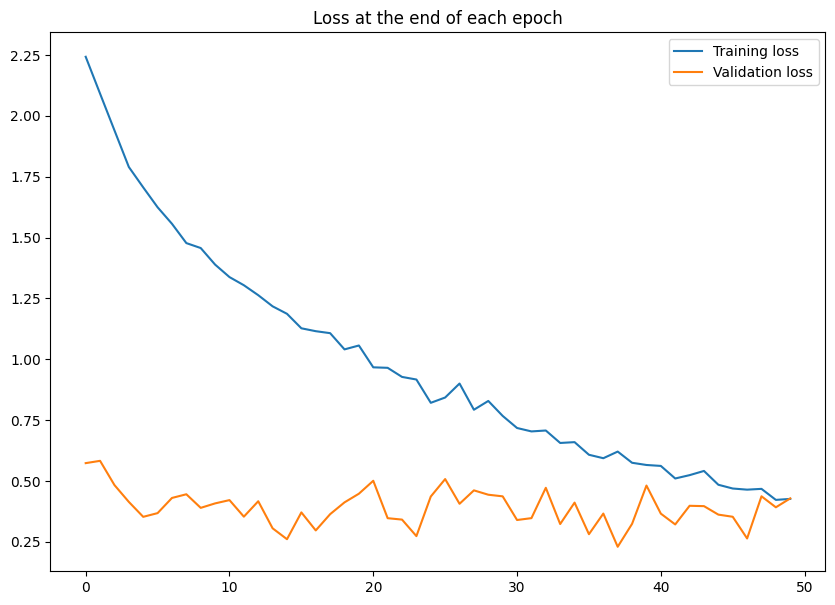

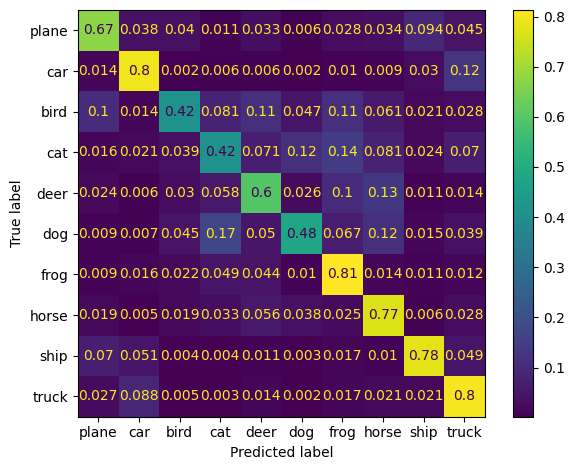

In [17]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


Test Accuracy: 65.5%


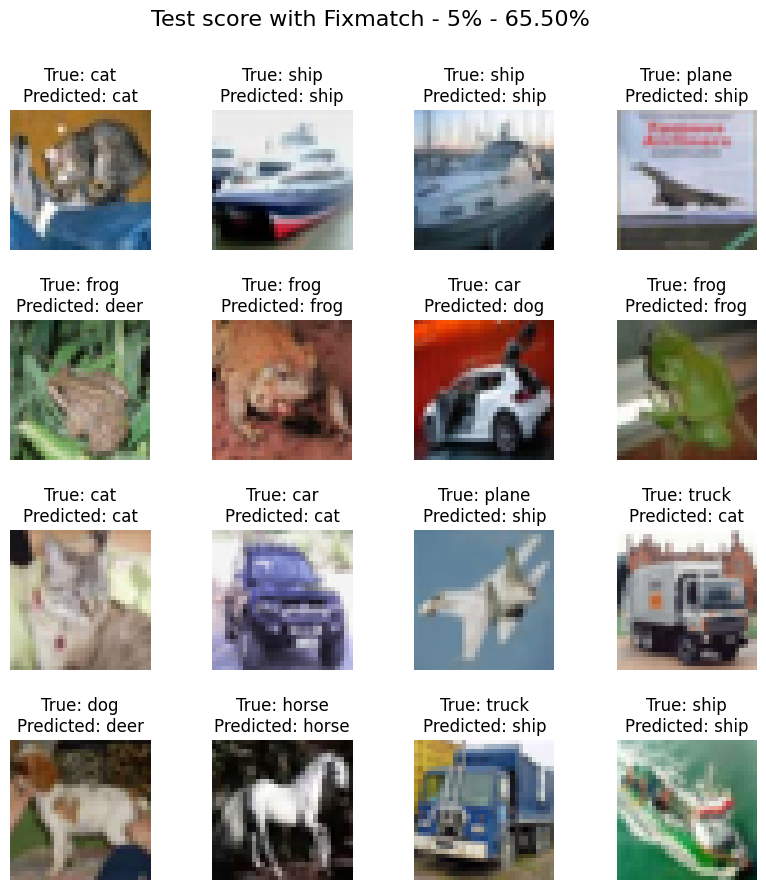

In [18]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")

### III.3 Fixmatch on 1% train data

In [19]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.01

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), 
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)),
)

strong_transform = K.ImageSequential(
    K.auto.RandAugment(n=2, m=10), # randaugment + cutout
)

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [20]:
print("Start training")

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    max_confidence = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # normalize
        weak_labeled_inputs = normalize(data=weak_labeled_inputs, mean=mean, std=std)
        weak_unlabeled_inputs = normalize(data=weak_unlabeled_inputs, mean=mean, std=std)
        strong_unlabeled_inputs = normalize(data=strong_unlabeled_inputs, mean=mean, std=std)

        # Compute mask, confidence
        pseudo_labels, idx, max_qb = mask(model, weak_unlabeled_inputs)
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        max_confidence = max(max_confidence, max_qb.max().item())

        

        # update progress bar
        pbar.set_postfix({
            "total loss": loss.item(),
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "confidence": max_confidence,
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr'].item()
        })

    # update loss
    train_losses.append(running_loss / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)


Start training


Epoch     0:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     1:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     2:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     3:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 13.83%


Epoch     4:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 19.62%


Epoch     5:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 21.2%


Epoch     6:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 21.15%


Epoch     7:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 23.06%


Epoch     8:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 28.04%


Epoch     9:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 25.64%


Epoch    10:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 31.28%


Epoch    11:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 29.8%


Epoch    12:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 29.55%


Epoch    13:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.26%


Epoch    14:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.9%


Epoch    15:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 25.3%


Epoch    16:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.87%


Epoch    17:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.8%


Epoch    18:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.49%


Epoch    19:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.21%


Epoch    20:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.45%


Epoch    21:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.38%


Epoch    22:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.7%


Epoch    23:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.02%


Epoch    24:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.26%


Epoch    25:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.33%


Epoch    26:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.98%


Epoch    27:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.37%


Epoch    28:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.71%


Epoch    29:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.22%


Epoch    30:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.22%


Epoch    31:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.45%


Epoch    32:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.65%


Epoch    33:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.36%


Epoch    34:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.57%


Epoch    35:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.68%


Epoch    36:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.64%


Epoch    37:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.8%


Epoch    38:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.34%


Epoch    39:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.61%


Epoch    40:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.98%


Epoch    41:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.44%


Epoch    42:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.49%


Epoch    43:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.37%


Epoch    44:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.77%


Epoch    45:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.02%


Epoch    46:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.66%


Epoch    47:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.07%


Epoch    48:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.23%


Epoch    49:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.32%


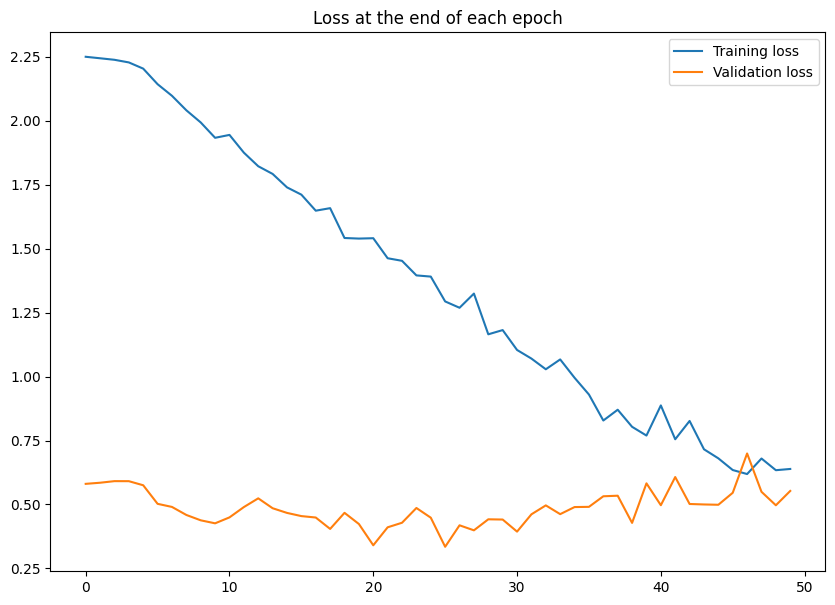

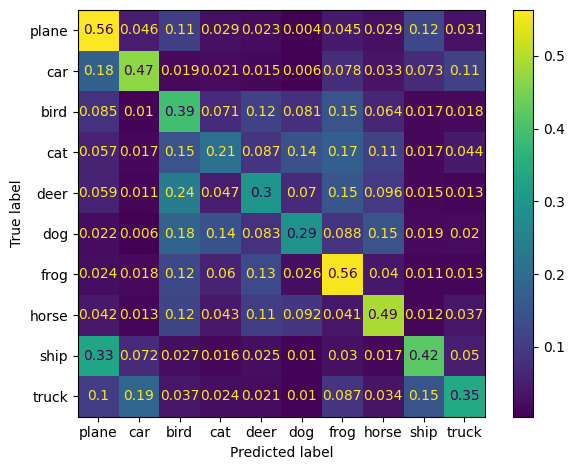

In [21]:
# plot losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()


Test Accuracy: 40.32%


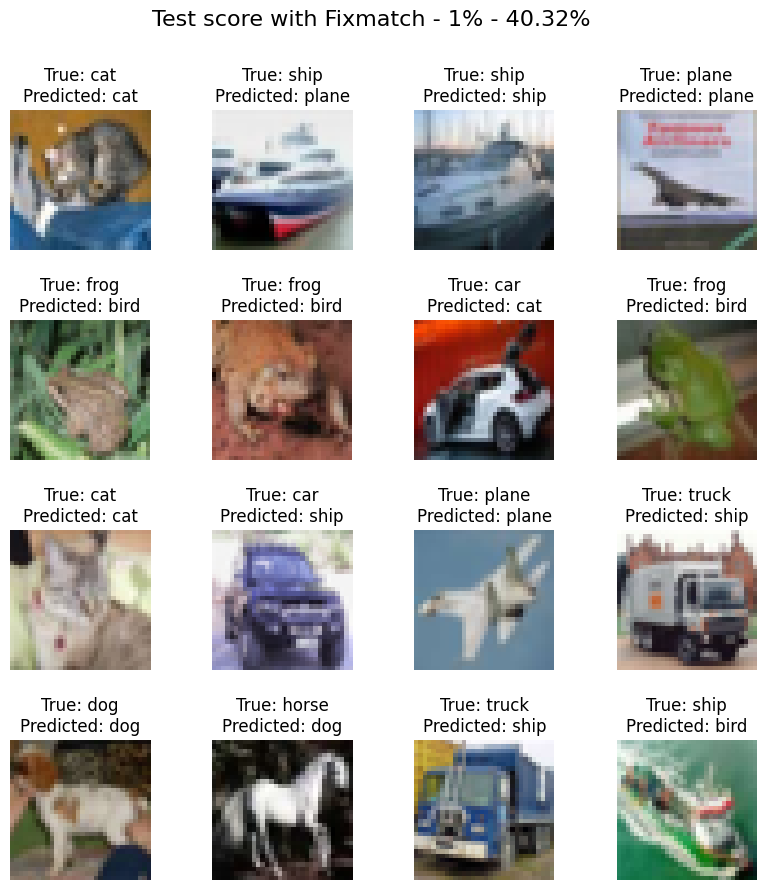

In [22]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1_fixmatch.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch.png")